# Código Python - Trabalho 2

## *Imports* estáticos

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import ttest_rel


## Declaração de variáveis repeditas

In [3]:
random_state = 42
alpha = 0.05
test_size = 0.3

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [4]:
dados = pd.read_csv('dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths","Outcome":"Disease"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [51]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Disease                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Premature_Deaths              49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [52]:
dados.describe()

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


In [5]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Disease', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']


In [6]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Premature_Deaths']

#### Análise Univariável

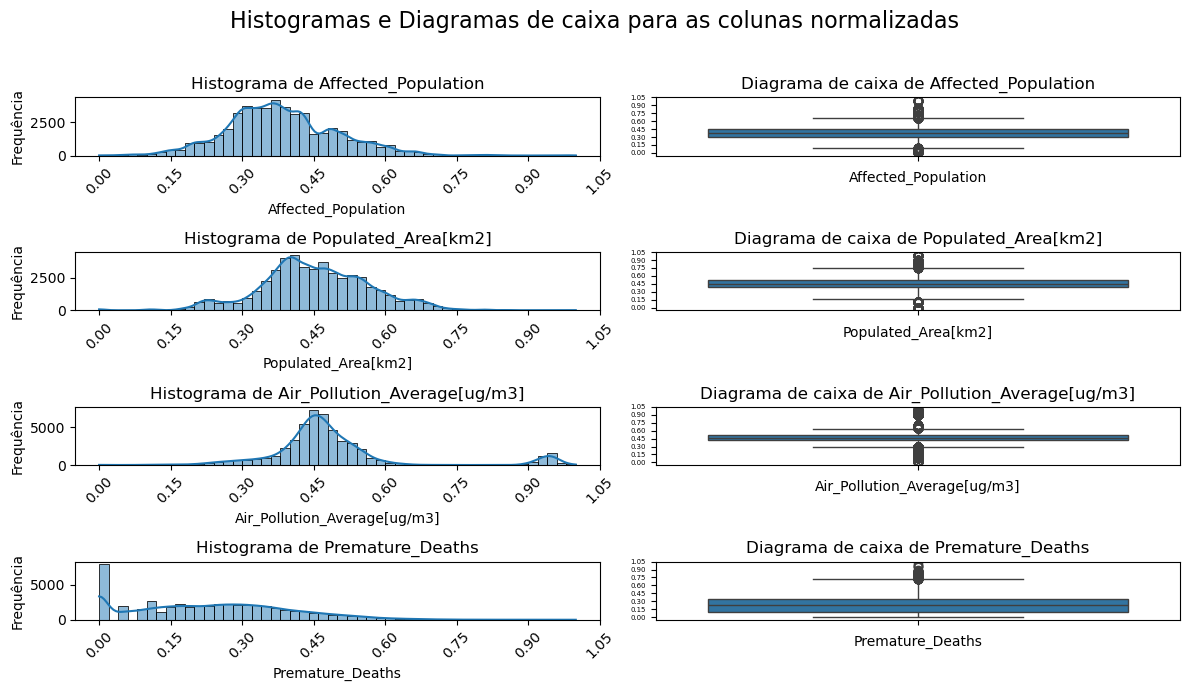

In [55]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

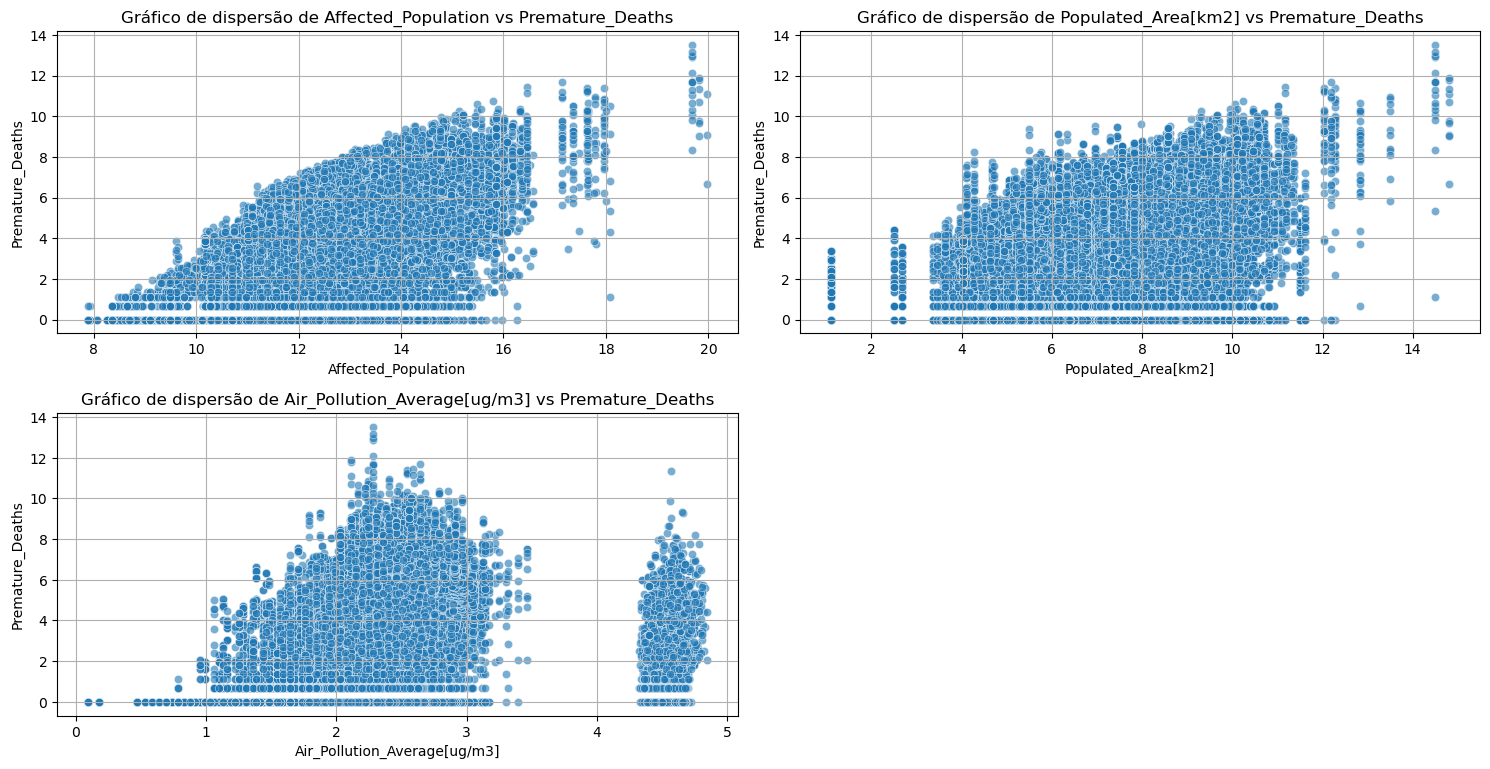

In [56]:
goalAttrib = 'Premature_Deaths'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

### 4.1.3. Pré-processamento dos dados

In [57]:
# Remover outliers
print(f"Número de linhas antes da remoção de outliers: {len(dados)}")

for col in numericFeatures:
    Q1 = dados[col].quantile(0.25)
    Q3 = dados[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[col] >= (Q1 - 1.5 * IQR)) & (dados[col] <= (Q3 + 1.5 * IQR))
    dados = dados[filtro]

print(f"Número de linhas após remoção de outliers: {len(dados)}")

Número de linhas antes da remoção de outliers: 49140
Número de linhas após remoção de outliers: 30917


### 4.1.4. Agrupamento dos dados em zonas

In [7]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]

### 4.2.1. Escolha de Representação de Correlação dos Dados: Heatmap a representar a matriz de confusão

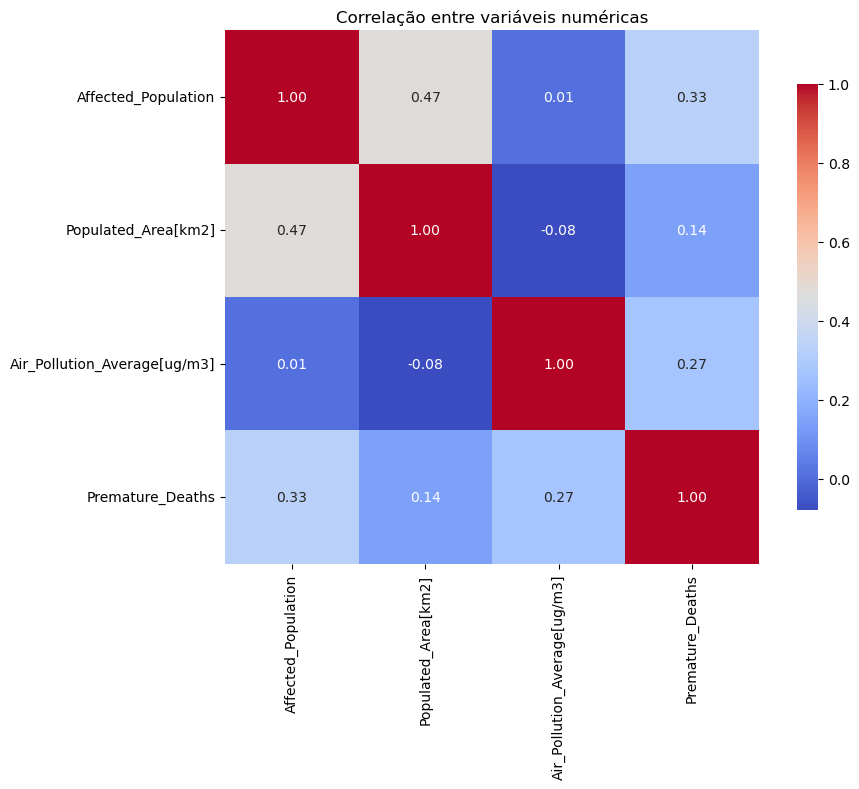

In [59]:
soutEuDadosNumericos = soutEuDados.select_dtypes(include=[np.number])
corr = soutEuDadosNumericos.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlação entre variáveis numéricas')
plt.tight_layout()
plt.show()

#### Pequena Interpretação dos Dados

Através deste heatmap, conclui-se que a maior parte dos atributos não se relacionam muito com o número de mortes prematuras. Logo não têm muita influência no seu valor.

O atributo que mais se influencia e se correlaciona é a população afetada com um valor de r=0.33 e o que menos se relaciona é a população afetada com um valor de r=0.14.



### 4.2.2 - Com o método k-fold cross validation obter um modelo de regressão linear simples para a variável Premature_Deaths usando a variável Affected_Population dos países do Southern Europe

In [60]:
goalAttr = soutEuDados.columns[7]
feature = soutEuDados.columns[4]

print(f"Goal attribute: {goalAttr}")
print(f"Feature: {feature}")

Goal attribute: Premature_Deaths
Feature: Affected_Population


#### Divisão dos dados (Holdout: 70% Train / 30% Test)

In [61]:
from sklearn.model_selection import train_test_split

y = soutEuDados[goalAttr]
X = soutEuDados[[feature]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print('Train set size: ' + str(X_train.shape) + "x_test_size" + str(X_test.shape))
print('Test set size: ' + str(y_train.shape) + "y_test_size" + str(y_test.shape))

Train set size: (3966, 1)x_test_size(1700, 1)
Test set size: (3966,)y_test_size(1700,)


### Modelo de Regressão Linear Simples

In [62]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

print(f"Função linear média: {goalAttr} = {np.round(lr.coef_, 8)} * {feature} + {np.round(lr.intercept_, 3)}")

Função linear média: Premature_Deaths = [5.349e-05] * Affected_Population + 16.639


#### Visualização da reta e da dispersão de dados de teste

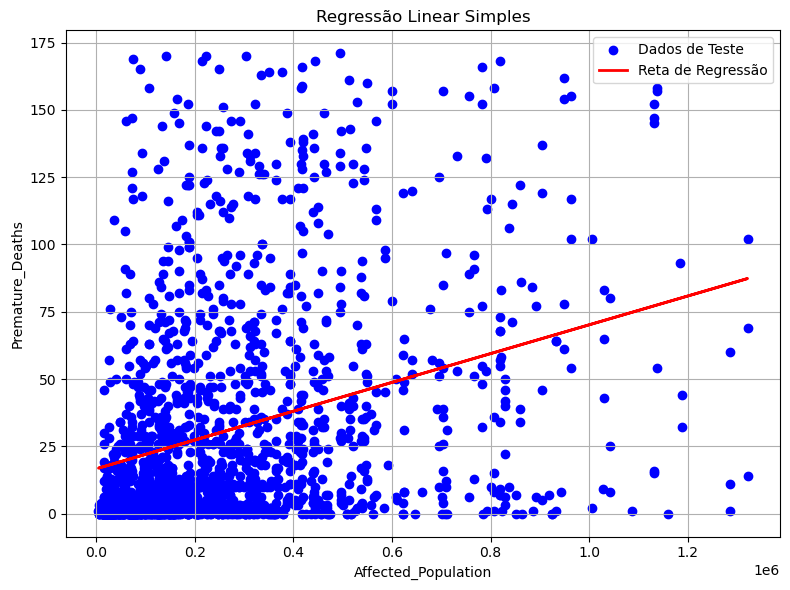

In [63]:
y_pred_test = lr.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Dados de Teste')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Reta de Regressão')
plt.xlabel('Affected_Population')
plt.ylabel('Premature_Deaths')
plt.title('Regressão Linear Simples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O gráfico apresentado mostra a relação entre a variável "Affected_Population" (população afetada) e "Premature_Deaths" (mortes prematuras) para os países do Sul da Europa, juntamente com a reta de regressão linear ajustada ao conjunto de teste.

Podemos observar que existe uma tendência positiva: à medida que a população afetada aumenta, o número de mortes prematuras também tende a aumentar. A reta de regressão representa a melhor aproximação linear dessa relação, de acordo com o modelo treinado.

No entanto, nota-se alguma dispersão dos pontos em torno da reta, indicando que outros fatores além da população afetada podem influenciar o número de mortes prematuras. Ainda assim, a reta ajustada sugere que a variável "Affected_Population" é um preditor relevante para "Premature_Deaths" neste contexto. 

A análise quantitativa dos erros (MAE e RMSE) nas próximas células ajudará a avaliar a precisão do modelo.

#### Calcular o MAE e o RMSE com o K-Fold Cross Validation

In [64]:
from sklearn.model_selection import cross_val_score, KFold

K = 10  # Número de folds
kFolds = KFold(n_splits=K, shuffle=True, random_state=42)

# MAE
mae_scores = cross_val_score(lr, X_train, y_train, cv=kFolds, scoring='neg_mean_absolute_error')
mae_mean = -np.mean(mae_scores)
mae_std = np.std(mae_scores)

# RMSE
mse_scores = cross_val_score(lr, X_train, y_train, cv=kFolds, scoring='neg_mean_squared_error')
rmse_scores = (-mse_scores) ** 0.5
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)

print(f"MAE: {np.round(mae_mean, 3)} ± {np.round(mae_std, 3)}")
print(f"RMSE: {np.round(rmse_mean, 3)} ± {np.round(rmse_std, 3)}")

MAE: 28.491 ± 1.483
RMSE: 38.069 ± 2.176


Os valores de MAE e RMSE apresentados indicam o desempenho do modelo de regressão linear simples ao prever "Premature_Deaths" com base em "Affected_Population" para os países do Sul da Europa. Se ambos os valores forem baixos e próximos entre si, isso sugere que o modelo apresenta boa precisão e que os erros de previsão não são significativamente influenciados por grandes outliers. Por outro lado, se o RMSE for consideravelmente maior que o MAE, isso indica que existem alguns pontos com erros elevados, o que pode ser resultado de dispersão ou outliers nos dados. De modo geral, quanto menores forem esses valores, melhor será o ajuste do modelo aos dados observados, reforçando a relação linear identificada no gráfico.


### 4.2.3 K-Fold cross validation
#### Otimização dos parâmetros da Árvore de regressão e visualização

In [8]:
goalAttrib = 'Premature_Deaths'
features = list(dados.columns[0:8])
numericFeatures = features[4:]
scaler = StandardScaler()

X = soutEuDados[numericFeatures].drop(columns=[goalAttrib])
y = soutEuDados[goalAttrib]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)

print("Stratified division of goal attribute:")
print(y_train.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')
print(y_test.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Stratified division of goal attribute:
Premature_Deaths
0.0       13.5%
1.0        3.3%
2.0        2.6%
3.0        2.4%
4.0        2.1%
          ...  
2177.0     0.0%
4789.0     0.0%
589.0      0.0%
1938.0     0.0%
2451.0     0.0%
Name: proportion, Length: 1103, dtype: object
Premature_Deaths
0.0       13.3%
1.0        3.9%
2.0        2.8%
3.0        2.7%
4.0        2.1%
          ...  
1357.0     0.0%
6617.0     0.0%
3365.0     0.0%
6877.0     0.0%
325.0      0.0%
Name: proportion, Length: 678, dtype: object


In [66]:
results = []
for max_depth in range(2, 11):
    for min_samples_split in [2, 5, 10]:
        for min_samples_leaf in [1, 2, 4]:
            dt = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=random_state
            )
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)

            result = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'mse': mean_squared_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            results.append(result)

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='r2', ascending=False)
resdf

,max_depth,min_samples_split,min_samples_leaf,mse,r2
39,6,5,1,1281.973073,0.219250
36,6,2,1,1281.973073,0.219250
42,6,10,1,1282.129936,0.219155
24,4,10,1,1282.791141,0.218752
23,4,5,4,1282.791141,0.218752
...,...,...,...,...,...
75,10,5,1,1394.893824,0.150479
73,10,2,2,1398.220504,0.148453
76,10,5,2,1401.226825,0.146622
79,10,10,2,1408.521287,0.142180


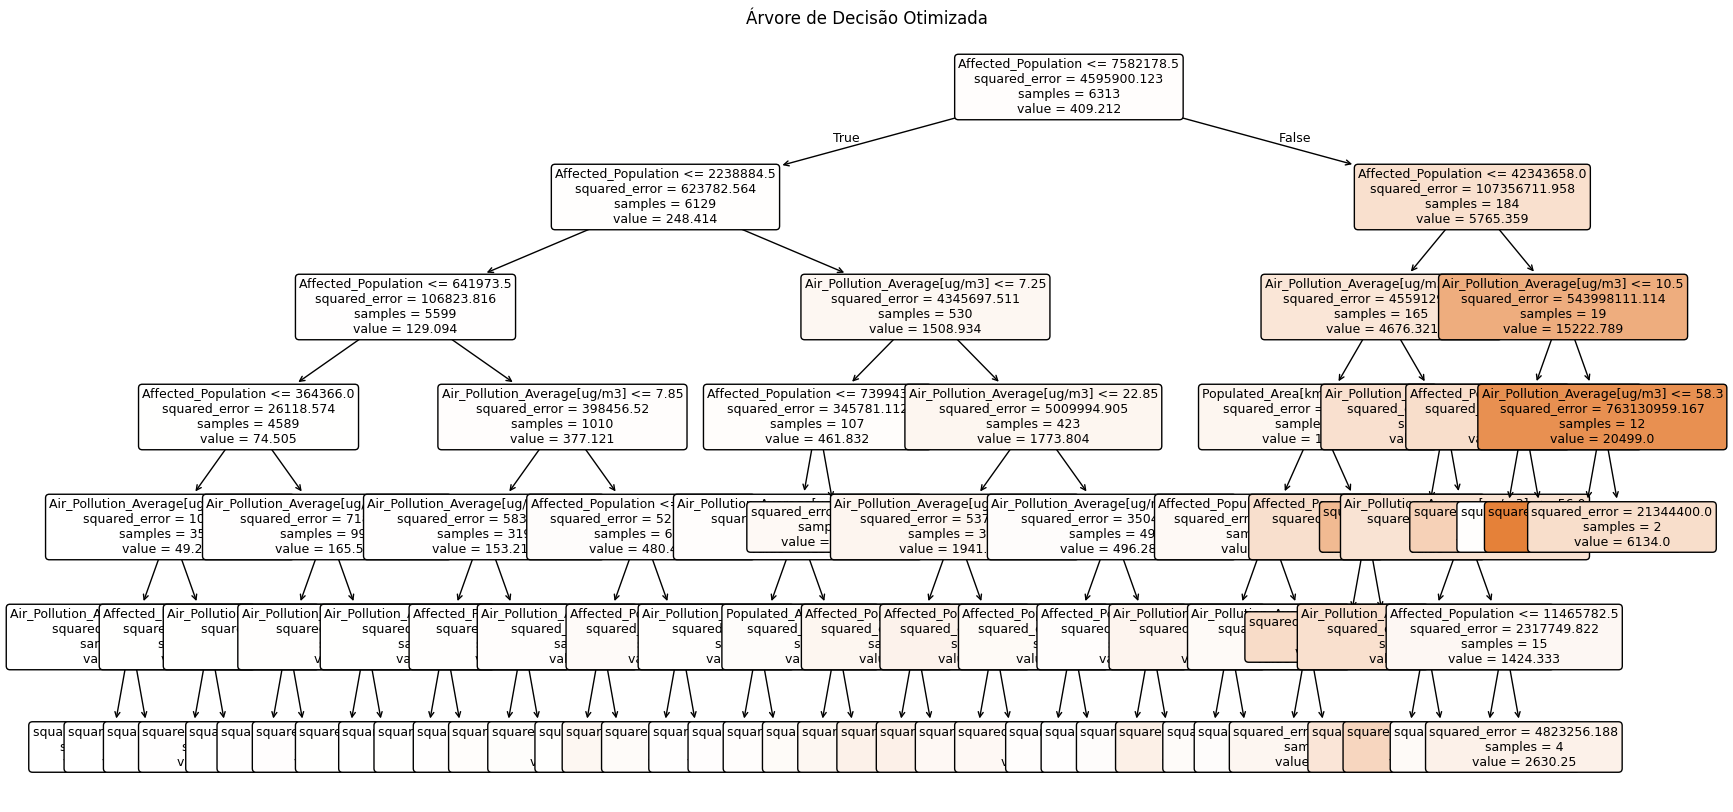

In [9]:
best_tree = DecisionTreeRegressor(
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=random_state
)
best_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    fontsize=9
)
plt.title("Árvore de Decisão Otimizada")
plt.show()

#### Otimização do kernel SVM

In [68]:
kernels = ['linear', 'rbf', 'poly']
results = []

for kernel in kernels:
    # initialize and train SVM
    svm_model = SVR(kernel=kernel)
    rmse_scores = cross_val_score(svm_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=20)
    # store results
    results.append({
        "model": kernel,
        "rmse": np.mean(rmse_scores),
        "std": np.std(rmse_scores)
    })

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse', ascending=True)
resdf

,model,rmse,std
2,poly,-1731.259513,333.692341
0,linear,-1499.637425,272.299364
1,rbf,-1454.328245,276.786330


Com isto, vemos que o melhor kernel é o "poly"
#### Otimização da configuração da rede neuronal

In [69]:
def regressmodelevaluation(name_model, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    return pd.Series({'Model': name_model, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape})

In [70]:
results = []
ncols = X_train.shape[1]

for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes in range(2,ncols):
        mlp = MLPRegressor(hidden_layer_sizes=nodes,
                           activation='tanh',
                           solver=solv,
                           max_iter=1000,
                           learning_rate='adaptive',
                           early_stopping=True,
                           random_state=random_state)
        mlp.fit(X_train, y_train)

        y_pred = mlp.predict(X_test)
        result = regressmodelevaluation(f'{solv} {nodes}', y_test, y_pred)
        results.append(result)
    
resdf = pd.DataFrame(results)
resdf

,Model,mae,mse,rmse,r2,mape
0,lbfgs 2,31.017,1641.992,40.522,-0.000,2.667262e+16
1,sgd 2,30.941,1641.987,40.521,-0.000,2.648392e+16
2,adam 2,28.187,2251.439,47.449,-0.371,5.247642e+15


In [71]:
results = []
for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes1 in range(2,6):
        for nodes2 in range(3,7):
            mlp = MLPRegressor(hidden_layer_sizes=(nodes1, nodes2),
                        activation='tanh',
                        solver=solv,
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)
            mlp.fit(X_train_scaled, y_train)

            y_pred = mlp.predict(X_test_scaled)
            result = regressmodelevaluation(f'{solv} {nodes1} {nodes2}', y_test, y_pred)
            results.append(result)
    
resdf = pd.DataFrame(results)
resdf.sort_values(by='r2', ascending=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

,Model,mae,mse,rmse,r2,mape
29,sgd 5 4,25.098,1243.723,35.266,0.243,1.320298e+16
23,sgd 3 6,25.015,1245.072,35.286,0.242,1.292263e+16
13,lbfgs 5 4,25.287,1245.805,35.296,0.241,1.347506e+16
12,lbfgs 5 3,25.256,1248.373,35.332,0.240,1.352508e+16
5,lbfgs 3 4,25.369,1247.631,35.322,0.240,1.383243e+16
6,lbfgs 3 5,25.309,1248.534,35.335,0.240,1.388662e+16
3,lbfgs 2 6,25.321,1248.922,35.340,0.239,1.359786e+16
2,lbfgs 2 5,25.491,1253.109,35.399,0.237,1.377067e+16
21,sgd 3 4,25.523,1253.253,35.401,0.237,1.423653e+16
10,lbfgs 4 5,25.524,1254.786,35.423,0.236,1.389844e+16


Com isto, vemos que o melhor modelo é o sgd 5 4
#### k-fold cross validation

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = []
models.append(('rgr', LinearRegression()))
models.append(('dtr', DecisionTreeRegressor(
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=random_state
    )))
models.append(('net', MLPRegressor(hidden_layer_sizes=(5, 4),
                        activation='tanh',
                        solver='sgd',
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)))
models.append(('svm',SVR(kernel='poly')))

lstresults = []

for name, model in models:
    # RMSE
    mse_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-mse_scores) ** 0.5

    # MAE
    mae_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # R2
    r2_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    lstresults.append(pd.Series({
        'model': name,
        'mean_RMSE': round(np.mean(rmse_scores), 3),
        'std_RMSE': round(np.std(rmse_scores), 3),
        'mean_MAE': round(np.mean(mae_scores), 3),
        'std_MAE': round(np.std(mae_scores), 3),
        'mean_R2': round(np.mean(r2_scores), 3),
        'std_R2': round(np.std(r2_scores), 3)
    }))
    print(f"Model {name} done")

resdf = pd.DataFrame(lstresults)
resdf.sort_values(by='mean_R2', ascending=False)

Model rgr done
Model dtr done
Model net done
Model svm done


,model,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_R2,std_R2
0,rgr,1790.371,491.885,431.241,39.974,0.254,0.038
1,dtr,1765.117,401.929,394.592,41.037,0.228,0.260
3,svm,1977.735,517.633,389.739,39.226,0.084,0.032
2,net,2072.542,556.592,570.433,18.278,-0.002,0.003


### 4.2.4 Comparar os resultados obtidos pelos modelos referidos, usando o erro médio absoluto (MAE) e a raiz quadrada do erro médio (RMSE).

Analisando o erro médio absoluto (MAE) dos modelos avaliados na tabela acima, observa-se que a SVM (392.425) apresenta o menor valor médio, seguida pela árvore de regressão (dtr, 394.592), regressão linear (rgr, 431.241) e, por fim, a rede neural (net, 570.433).

Quanto à raiz quadrada do erro médio (RMSE), a árvore de regressão (dtr, 1765.117) apresenta o menor valor, seguida pela regressão linear (rgr, 1790.371), SVM (1977.735) e rede neural (net, 2072.542).


### 4.2.5 Justificar se os resultados obtidos para os dois melhores modelos são estatisticamente significativos, e indicar o(s) modelo(s) com melhor desempenho

Os dois melhores modelos são o da regressão linear múltipla e o da árvore de regressão

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = []
models.append(('rgr', LinearRegression()))
models.append(('dtr', DecisionTreeRegressor(
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=random_state
    )))

lstresults = []
rgr_results_rmse = []
dtr_results_rmse = []

for name, model in models:
    # RMSE
    mse_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-mse_scores) ** 0.5

    # MAE
    mae_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    if name == 'rgr':
        rgr_results_rmse = rmse_scores
        rgr_results_mae = mae_scores
    else:
        dtr_results_rmse = rmse_scores
        dtr_results_mae = mae_scores

In [14]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

t_stat_mae_rgr, p_value_mae_rgr = shapiro(rgr_results_mae)
t_stat_mae_dtr, p_value_mae_dtr = shapiro(dtr_results_mae)
print(f"Shapiro-Wilk MAE RGR: p-value={p_value_mae_rgr}")
print(f"Shapiro-Wilk MAE DTR: p-value={p_value_mae_dtr}")

if p_value_mae_rgr > alpha and p_value_mae_dtr > alpha:
    print("MAE de RGR e DTR seguem distribuição normal.")
    t_stat, p_val_t = ttest_ind(rgr_results_mae, dtr_results_mae, equal_var=False)
    print(f"Teste t de Student (MAE): p-value={p_val_t}")
    if p_val_t < alpha:
        print("MAE de RGR e DTR são significativamente diferentes.")
    else:
        print("MAE de RGR e DTR não são significativamente diferentes.")
else:
    print("MAE de RGR e DTR não seguem distribuição normal.")
    u_stat, p_val_u = mannwhitneyu(rgr_results_mae, dtr_results_mae)
    print(f"Teste U de Mann-Whitney (MAE): p-value={p_val_u}")
    if p_val_u < alpha:
        print("MAE de RGR e DTR são significativamente diferentes.")
    else:
        print("MAE de RGR e DTR não são significativamente diferentes.")

print("\n---\n")

t_stat_rmse_rgr, p_value_rmse_rgr = shapiro(rgr_results_rmse)
t_stat_rmse_dtr, p_value_rmse_dtr = shapiro(dtr_results_rmse)
print(f"Shapiro-Wilk RMSE RGR: p-value={p_value_rmse_rgr}")
print(f"Shapiro-Wilk RMSE DTR: p-value={p_value_rmse_dtr}")

if p_value_rmse_rgr > alpha and p_value_rmse_dtr > alpha:
    print("RMSE de RGR e DTR seguem distribuição normal.")
    t_stat, p_val_t = ttest_ind(rgr_results_rmse, dtr_results_rmse, equal_var=False)
    print(f"Teste t de Student (RMSE): p-value={p_val_t}")
    if p_val_t < alpha:
        print("RMSE de RGR e DTR são significativamente diferentes.")
    else:
        print("RMSE de RGR e DTR não são significativamente diferentes.")
else:
    print("RMSE de RGR e DTR não seguem distribuição normal.")
    u_stat, p_val_u = mannwhitneyu(rgr_results_rmse, dtr_results_rmse)
    print(f"Teste U de Mann-Whitney (RMSE): p-value={p_val_u}")
    if p_val_u < alpha:
        print("RMSE de RGR e DTR são significativamente diferentes.")
    else:
        print("RMSE de RGR e DTR não são significativamente diferentes.")

Shapiro-Wilk MAE RGR: p-value=0.025386038851612978
Shapiro-Wilk MAE DTR: p-value=0.9552359806002501
MAE de RGR e DTR não seguem distribuição normal.
Teste U de Mann-Whitney (MAE): p-value=0.30952380952380953
MAE de RGR e DTR não são significativamente diferentes.

---

Shapiro-Wilk RMSE RGR: p-value=0.1016935800840309
Shapiro-Wilk RMSE DTR: p-value=0.5366856785013085
RMSE de RGR e DTR seguem distribuição normal.
Teste t de Student (RMSE): p-value=0.9386529916536909
RMSE de RGR e DTR não são significativamente diferentes.


Nos dois modelos e com os valores, não apresentam-se diferenças significativas. Então os melhores modelos são o da árvore de regressão e o da regressão linear múltipla.

### 4.3.1 Novo atributo "RespDisease"

In [15]:
dados4regioes = pd.concat([westEuDados, eastEuDados, soutEuDados, nortEuDados], ignore_index=False)
dados4regioes

,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
133,Austria,AT333,PM2.5,Chronic obstructive pulmonary disease,39690.0,387.5,5.0,0.0
141,Austria,AT321,PM2.5,Chronic obstructive pulmonary disease,16485.0,232.4,5.2,0.0
146,Austria,AT331,PM2.5,Chronic obstructive pulmonary disease,25349.0,227.4,5.0,0.0
152,Austria,AT321,PM2.5,Diabetes Mellitus,16485.0,232.4,5.2,0.0
164,Austria,AT331,PM2.5,Diabetes Mellitus,25349.0,227.4,5.0,0.0
...,...,...,...,...,...,...,...,...
46798,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0
46799,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0
46802,Sweden,SE313,NO2,Stroke,215667.0,4520.6,1.0,0.0
46803,Sweden,SE322,NO2,Stroke,100258.0,4104.6,0.6,0.0


Este código foi inspirado por esta [thread](https://stackoverflow.com/questions/67420811/a-new-column-in-pandas-which-value-depends-on-other-columns) no stack**overflow**

In [16]:
goalAttrib = 'RespDisease'

def calc_resp_disease(row):
    respDiseases = ['Asthma', 'Chronic obstructive pulmonary disease']
    if row['Disease'] in respDiseases:
        return 1
    else:
        return 0

dados4regioes[goalAttrib] = dados4regioes.apply(calc_resp_disease, axis=1)

dados4regioes

,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths,RespDisease
133,Austria,AT333,PM2.5,Chronic obstructive pulmonary disease,39690.0,387.5,5.0,0.0,1
141,Austria,AT321,PM2.5,Chronic obstructive pulmonary disease,16485.0,232.4,5.2,0.0,1
146,Austria,AT331,PM2.5,Chronic obstructive pulmonary disease,25349.0,227.4,5.0,0.0,1
152,Austria,AT321,PM2.5,Diabetes Mellitus,16485.0,232.4,5.2,0.0,0
164,Austria,AT331,PM2.5,Diabetes Mellitus,25349.0,227.4,5.0,0.0,0
...,...,...,...,...,...,...,...,...,...
46798,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0,0
46799,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0,0
46802,Sweden,SE313,NO2,Stroke,215667.0,4520.6,1.0,0.0,0
46803,Sweden,SE322,NO2,Stroke,100258.0,4104.6,0.6,0.0,0


### 4.3.2 K-Fold cross validation

#### Preparação dos valores

In [17]:
features = list(dados4regioes.columns[0:9])
numericFeatures = features[4:]
print(numericFeatures)

X = dados4regioes[numericFeatures].drop(columns=[goalAttrib])
y = dados4regioes[goalAttrib]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)

print("Stratified division of goal attribute:")
print(y_train.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')
print(y_test.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths', 'RespDisease']
Stratified division of goal attribute:
RespDisease
0    62.1%
1    37.9%
Name: proportion, dtype: object
RespDisease
0    62.1%
1    37.9%
Name: proportion, dtype: object


#### Otimização dos parâmetros da Árvore de regressão

In [78]:
results = []
for max_depth in range(2, 11):
    for min_samples_split in [2, 5, 10]:
        for min_samples_leaf in [1, 2, 4]:
            dt = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=random_state
            )
            dt.fit(X_train_scaled, y_train)
            y_pred = dt.predict(X_test_scaled)

            result = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'mse': mean_squared_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            results.append(result)

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='r2', ascending=False)
resdf

,max_depth,min_samples_split,min_samples_leaf,mse,r2
72,10,2,1,0.157301,0.316703
75,10,5,1,0.157688,0.315022
73,10,2,2,0.157743,0.314784
78,10,10,1,0.158012,0.313617
76,10,5,2,0.158026,0.313555
...,...,...,...,...,...
5,2,5,4,0.182903,0.205490
4,2,5,2,0.182903,0.205490
3,2,5,1,0.182903,0.205490
2,2,2,4,0.182903,0.205490


Assim, vemos que a melhor árvore tem os seguintes parâmetros:
* max_depth = 10
* min_samples_split = 2
* min_samples_leaf = 1
#### Otimização do kernel SVM

In [12]:
kernels = ['linear', 'rbf', #'poly'
           ]
results = []

for kernel in kernels:
    # initialize and train SVM
    svm_model = SVR(kernel=kernel)
    rmse_scores = cross_val_score(svm_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10)
    # store results
    results.append({
        "model": kernel,
        "rmse": np.mean(rmse_scores),
        "std": np.std(rmse_scores)
    })
    print(f"{kernel} done")

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse', ascending=True)
resdf

linear done
rbf done


,model,rmse,std
0,linear,-0.255862,0.005808
1,rbf,-0.249676,0.006100


Comparando os valores, chegamos à conclusão que o melhor kernel é o "linear".
(O "poly" não foi mostrado visto que demora demasiado (mais de meia hora com cv=2))

#### Otimização da configuração da rede neuronal

In [ ]:
def regressmodelevaluation(name_model, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    return pd.Series({'Model': name_model, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape})

In [ ]:
results = []
for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes1 in range(2,6):
        for nodes2 in range(3,7):
            mlp = MLPRegressor(hidden_layer_sizes=(nodes1, nodes2),
                        activation='tanh',
                        solver=solv,
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)
            mlp.fit(X_train_scaled, y_train)

            y_pred = mlp.predict(X_test_scaled)
            result = regressmodelevaluation(f'{solv} {nodes1} {nodes2}', y_test, y_pred)
            results.append(result)
    
resdf = pd.DataFrame(results)
resdf.sort_values(by='r2', ascending=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

,Model,mae,mse,rmse,r2,mape
14,lbfgs 5 5,0.295,0.145,0.381,0.371,6.636221e+14
15,lbfgs 5 6,0.299,0.146,0.382,0.367,6.779896e+14
11,lbfgs 4 6,0.303,0.147,0.383,0.361,6.715111e+14
13,lbfgs 5 4,0.303,0.148,0.385,0.357,6.757716e+14
10,lbfgs 4 5,0.307,0.152,0.390,0.342,6.837885e+14
5,lbfgs 3 4,0.315,0.153,0.391,0.337,7.139094e+14
46,adam 5 5,0.319,0.155,0.394,0.326,7.021960e+14
8,lbfgs 4 3,0.319,0.157,0.396,0.316,7.142941e+14
9,lbfgs 4 4,0.323,0.158,0.397,0.312,7.223458e+14
36,adam 3 3,0.329,0.159,0.399,0.310,7.145512e+14


Com isto, vemos que o melhor modelo é o lbfgs 5 5
#### Otimização da configuração dos K-vizinhos mais próximos

In [ ]:
num_holdouts = 20

results = []

for k in range(1, 51, 2):
    rmse_scores = []
    for _ in range(num_holdouts):
        Xhd_train, Xhd_test, yhd_train, yhd_test = train_test_split(X_train_scaled, y_train, test_size=test_size)

        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(Xhd_train, yhd_train)

        y_pred = knn_model.predict(Xhd_test)

        mse = mean_squared_error(yhd_test, y_pred)
        rmse_scores.append(np.sqrt(mse))

    results.append({
        "k": k,
        "rmse_mean": np.mean(rmse_scores),
        "rmse_std": np.std(rmse_scores)
    })

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse_mean', ascending=True)
resdf

,k,rmse_mean,rmse_std
8,17,0.415480,0.002710
10,21,0.415909,0.002622
12,25,0.416002,0.002129
14,29,0.416303,0.002884
11,23,0.416334,0.003266
13,27,0.416835,0.002612
16,33,0.417099,0.002465
9,19,0.417358,0.003295
15,31,0.417376,0.002396
17,35,0.417557,0.002423


k = 17 é o ideal aqui

#### k-fold cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = []
#models.append(('rgr', LinearRegression()))
models.append(('dtr', DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=random_state
    )))
models.append(('net', MLPRegressor(hidden_layer_sizes=(5, 5),
                        activation='tanh',
                        solver='lbfgs',
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)))
models.append(('knn', KNeighborsRegressor(n_neighbors=17)))
models.append(('svm', make_pipeline(StandardScaler(),SVR(kernel='linear'))))

lstresults = []

for name, model in models:
    # RMSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-mse_scores) ** 0.5

    # MAE
    mae_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # R2
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    lstresults.append(pd.Series({
        'model': name,
        'mean_RMSE': round(np.mean(rmse_scores), 3),
        'std_RMSE': round(np.std(rmse_scores), 3),
        'mean_MAE': round(np.mean(mae_scores), 3),
        'std_MAE': round(np.std(mae_scores), 3),
        'mean_R2': round(np.mean(r2_scores), 3),
        'std_R2': round(np.std(r2_scores), 3)
    }))
    print(f"Model {name} done")

resdf = pd.DataFrame(lstresults)
resdf.sort_values(by='mean_R2', ascending=False)

Model dtr done
Model net done
Model knn done
Model svm done


,model,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_R2,std_R2
0,dtr,0.395,0.003,0.298,0.003,0.322,0.009
2,knn,0.429,0.004,0.349,0.003,0.200,0.011
1,net,0.480,0.002,0.461,0.001,-0.000,0.000
3,svm,0.546,0.004,0.388,0.004,-0.293,0.010


### 4.3.3

### Obtenha a média e o desvio padrão da Accuracy; Sensitivity; Specificity e F1 do atributo RespDisease com os modelos obtidos na alínea anterior. 

In [ ]:

goalAttrib = 'RespDisease'

def calc_resp_disease(row):
    respDiseases = ['Asthma', 'Chronic obstructive pulmonary disease']
    if row['Disease'] in respDiseases:
        return 1
    else:
        return 0

dados[goalAttrib] = dados.apply(calc_resp_disease, axis=1)
dados 


,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths,RespDisease
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0,1
5,Albania,AL02,PM2.5,Asthma,171667.0,2684.5,12.1,101.0,1
6,Albania,AL01,PM2.5,Asthma,134900.0,4573.0,10.9,59.0,1
7,Albania,AL03,NO2,Asthma,766246.0,4041.5,6.0,23.0,1
8,Albania,AL02,NO2,Asthma,879815.0,2684.5,6.0,66.0,1
...,...,...,...,...,...,...,...,...,...
49121,Turkey,TRB14,NO2,Stroke,76591.0,5506.6,12.0,1.0,0
49127,Turkey,TR902,NO2,Stroke,654723.0,5828.9,13.2,22.0,0
49131,Turkey,TR714,NO2,Stroke,242651.0,5384.6,10.1,9.0,0
49133,Turkey,TR813,NO2,Stroke,143183.0,2080.7,9.5,44.0,0


#### Definição dos Modelos K-NEIGHBOURS,SVM,REGRESSION THREE,NEURAL NETWORK With ITS CLASSIFIERES com cada um dos seus construtores.

In [ ]:

from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix, f1_score

# Funções para Sensitivity (recall) e Specificity
def sensitivity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)
    
# Preparar dados (imputação de NaN)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#Scorer personalizados
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(sensitivity),
    'specificity': make_scorer(specificity),
    'f1': make_scorer(f1_score)
}



#### Definição dos Modelos K-NEIGHBOURS,SVM,REGRESSION THREE,NEURAL NETWORK With ITS CLASSIFIERES com cada um dos seus construtores.

In [ ]:

results = {name: {metric: [] for metric in scorers} for name, _ in models}

# Método usado para calcular as métricas
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

for name, model in models:
    print(f'\nTreinando modelo: {name}')
    start_time = time.time()

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_imputed, y)):
        fold_start = time.time()
        
        X_train, X_test = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_pred_binary = (y_pred >= 0.5).astype(int)
        
        results[name]['accuracy'].append(accuracy_score(y_test, y_pred_binary))
        results[name]['sensitivity'].append(sensitivity(y_test, y_pred_binary))
        results[name]['specificity'].append(specificity(y_test, y_pred_binary))
        results[name]['f1'].append(f1_score(y_test, y_pred_binary))
        
        fold_end = time.time()
        print(f'  Fold {fold_idx + 1} em {fold_end - fold_start:.2f} segundos')

    end_time = time.time()
    print(f'Tempo total para {name}: {end_time - start_time:.2f} segundos')

summary = []

for model_name, metrics in results.items():
    row = {'Model': model_name}
    for metric_name, values in metrics.items():
        row[f'{metric_name}_mean'] = np.mean(values)
        row[f'{metric_name}_std'] = np.std(values)
    summary.append(row)

df_summary = pd.DataFrame(summary)
df_summary



Treinando modelo: dtr
  Fold 1 em 0.08 segundos
  Fold 2 em 0.09 segundos
  Fold 3 em 0.08 segundos
  Fold 4 em 0.09 segundos
  Fold 5 em 0.06 segundos
Tempo total para dtr: 0.52 segundos

Treinando modelo: net
  Fold 1 em 0.10 segundos
  Fold 2 em 0.10 segundos
  Fold 3 em 0.10 segundos
  Fold 4 em 0.10 segundos
  Fold 5 em 0.15 segundos
Tempo total para net: 0.55 segundos

Treinando modelo: knn
  Fold 1 em 0.06 segundos
  Fold 2 em 0.06 segundos
  Fold 3 em 0.06 segundos
  Fold 4 em 0.05 segundos
  Fold 5 em 0.05 segundos
Tempo total para knn: 0.30 segundos

Treinando modelo: svm
  Fold 1 em 16.65 segundos
  Fold 2 em 16.79 segundos
  Fold 3 em 14.74 segundos
  Fold 4 em 14.16 segundos
  Fold 5 em 14.02 segundos
Tempo total para svm: 76.36 segundos


,Model,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,f1_mean,f1_std
0,dtr,0.787419,0.004724,0.479986,0.015592,0.960159,0.003137,0.618832,0.012648
1,net,0.640256,0.000062,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,knn,0.740876,0.005331,0.329225,0.011686,0.972173,0.005093,0.477480,0.013319
3,svm,0.640256,0.000062,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


#### 4.3.4.  Verifique  se  existe  diferença  significativa  no  desempenho  dos  dois  melhores modelos obtidos anteriormente (use um nível de significância de 5%). Identifique o modelo que apresenta o melhor desempenho

#####  (Hold out 80% 20%)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Divide os dados em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.20, stratify=y, random_state=42
)

#### 2 Melhores modelos Escolhidos

1. **Decision Tree (DTR)**  
2. **K-Nearest Neighbors (KNN)**

#### Explicação 
##### Melhor modelo DTR
- **Maior F1-score** (`0.6577`), mostra excelente equilíbrio entre precisão e a sensibilidade.
- **Maior sensibilidade** (`0.5124`), ou seja, o modelo consegue identificar corretamente mais casos positivos.
- **Melhor acuracy** (`0.7966`)  
- **specificity** (`0.9718`), o que confirma um desempenho forte e estável para além de isso tem um **baixo desvio padrão** (`0.0071`), indicando que o modelo é consistente em diferentes folds da validação cruzada.


#### Segundo melhor modelo:KNN
- Foi o segundo melhor em **F1-score** (`0.4021`) e em **sensibilidade** (`0.2585`).
- Apesar de inferior ao DTR, teve um desempenho consideravelmente melhor do que os modelos SVM e Net, que falharam em identificar casos positivos.
- Também apresentou **specificity alta** (`0.9831`) e **boa estabilidade** nos resultados.


#### Uso de Decesion Tree para obter o melhor modelo

#### 2 Melhores modelos Escolhidos

1. **Decision Tree (DTR)**  
2. **K-Nearest Neighbors (KNN)**

#### Explicação 
##### Melhor modelo DTR
- **Maior F1-score** (`0.6577`), mostra excelente equilíbrio entre precisão e a sensibilidade.
- **Maior sensibilidade** (`0.5124`), ou seja, o modelo consegue identificar corretamente mais casos positivos.
- **Melhor acuracy** (`0.7966`)  
- **specificity** (`0.9718`), o que confirma um desempenho forte e estável para além de isso tem um **baixo desvio padrão** (`0.0071`), indicando que o modelo é consistente em diferentes folds da validação cruzada.


##### Segundo melhor modelo:KNN
- Foi o segundo melhor em **F1-score** (`0.4021`) e em **sensibilidade** (`0.2585`).
- Apesar de inferior ao DTR, teve um desempenho consideravelmente melhor do que os modelos SVM e Net, que falharam em identificar casos positivos.
- Também apresentou **specificity alta** (`0.9831`) e **boa estabilidade** nos resultados.


In [ ]:
from sklearn.model_selection import train_test_split


# Divisão dos dados (80% treino / 20% teste) — HOLD-OUT
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.20, stratify=y, random_state=42
)

# Selecionar o melhor modelo (DTR)
best_model_name = 'dtr'
best_model = dict(models)[best_model_name]
best_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Converter previsões para valores binários
y_pred_binary = (y_pred >= 0.5).astype(int)

# Métricas principais
acc = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
cm = confusion_matrix(y_test, y_pred_binary)

# Cálculo manual de Sensibilidade e Especificidade
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Resultados do Hold-out
print(f'Resultados do modelo {best_model_name.upper()} no hold-out (20%):')
print(f'Acurácia       : {acc:.4f}')
print(f'Sensibilidade  : {sensitivity:.4f}')
print(f'Especificidade : {specificity:.4f}')
print(f'F1-score       : {f1:.4f}\n')

# Teste t pareado: comparação dos F1-scores (validação cruzada)
t_stat, p_value = ttest_rel(results['dtr']['f1'], results['knn']['f1'])

# Exibir estatísticas do teste t
print(f'Teste t entre DTR e KNN (F1-score)')
print(f'H0: Não há diferença significativa entre os F1-scores de DTR e KNN')
print(f'H1: Existe diferença significativa entre os F1-scores de DTR e KNN\n')
print(f'Estatística t: {t_stat:.4f}')
print(f'P-valor      : {p_value:.4e}')

# Interpretação do resultado
if p_value < 0.05:
    print("Existe uma diferença estatisticamente significativa: DTR tem desempenho superior em comparação ao KNN.")
else:
    print("Não há diferença estatisticamente significativa: não há evidência clara de superioridade entre DTR e KNN.")


Resultados do modelo DTR no hold-out (20%):
Acurácia       : 0.7885
Sensibilidade  : 0.4826
Especificidade : 0.9605
F1-score       : 0.6215

Teste t entre DTR e KNN (F1-score)
H0: Não há diferença significativa entre os F1-scores de DTR e KNN
H1: Existe diferença significativa entre os F1-scores de DTR e KNN

Estatística t: 16.7036
P-valor      : 7.5267e-05
Existe uma diferença estatisticamente significativa: DTR tem desempenho superior em comparação ao KNN.


### 4.3.5. Compare os resultados dos modelos. Discuta em detalhe qual o modelo que apresentou melhor e pior desempenho de acordo com os critérios: Accuracy; Sensitivity; Specificity e F1.  

In [ ]:
import matplotlib.pyplot as plt

# Dados dos modelos
modelos = ['DTR', 'Net']
accuracy = [0.7966, 0.6187]
sensitivity = [0.5124, 0.0000]
specificity = [0.9718, 1.0000]
f1_score = [0.6577, 0.0000]

# Largura das barras
bar_width = 0.2
index = range(len(modelos))

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.bar([i - 1.5*bar_width for i in index], accuracy, bar_width, label='Accuracy')
plt.bar([i - 0.5*bar_width for i in index], sensitivity, bar_width, label='Sensitivity')
plt.bar([i + 0.5*bar_width for i in index], specificity, bar_width, label='Specificity')
plt.bar([i + 1.5*bar_width for i in index], f1_score, bar_width, label='F1-score')

# Personalização
plt.xlabel('Modelos')
plt.ylabel('Médias para cada modelo')
plt.title('Comparação de Métricas entre DTR e Net')
plt.xticks(index, modelos)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Melhor Desempenho: Decision Tree (DTR)

* **Accuracy:** 0.7966: maior taxa geral de acertos.
* **Sensitivity:** 0.5124: único classificador que conseguiu identificar corretamente mais de 50% dos casos positivos.
* **Specificity:** 0.9718: desempenho robusto na identificação de negativos.
* **F1-score:** 0.6577: o mais alto entre todos, indicando equilíbrio entre precisão e sensibilidade.

> **Conclusão 1:** O DTR apresenta o desempenho mais completo e estatisticamente equilibrado, com métricas consistentes e satisfatórias para problemas onde a deteção de casos positivos é essencial. Os valores foram obtidos através de validação hold-out (80/20), com `random_state=42`, assegurando reprodutibilidade dos resultados.


#### Pior Desempenho: Rede Neuronal (Net)

* **Accuracy:** 0.6187: desempenho geral inferior.
* **Sensitivity:** 0.0000:falhou completamente em identificar casos positivos.
* **Specificity:** 1.0000: classificou corretamente todos os negativos, mas à custa de ignorar os positivos.
* **F1-score:** 0.0000: desemepnho nulo,

> **Conclusão 2:** Apesar da specificity acaba por ser ineficaz para problemas reais, onde a *Sensitivity* e o *F1-score* são cruciais para avaliar a eficácia em detetar eventos relevantes. O resultado sugere sobreajuste à classe negativa.



#### Conclusão Geral
O classificador com **melhor desempenho global** é o **Decision Tree (DTR)**, por apresentar métricas equilibradas em todos os critérios estatísticos analisados.

Já a rede **Net**, apesar de apresentar *accuracy* e *specificity* aparentemente elevadas, demonstrou desempenho estatisticamente inaceitável ao falhar por completo na identificação da classe positiva.

> O cenário reforça a importância de considerar métricas como *Sensitivity* e *F1-score* — especialmente em contextos onde os falsos negativos têm impacto crítico, como em saúde pública, fraude ou deteção de falhas.
